# 3. Asymptotic dynamics of the domain decomposition algorithm

In https://arxiv.org/abs/2001.10986 they provide a linear convergence rate for the iterates of the domain decomposition algorithm. This theoretical convergence rate however becomes exponentially bad as the problem size increases or $\varepsilon$ decreases. 

However, problem instances that suffer this problem must be maliciously crafted. For "geometrical" problems (i.e., with a smooth cost and partitions made by points that are "close"), the authors show numerically that the domain decomposition algorithm converges in a number of iterations that is _linear_ in the marginals size.

To understand better the fast convergence in geometrical problems, in https://arxiv.org/abs/2106.08084 we consider the sequence of trajectories obtained by applying the domain decomposition algorithm to finer and finer subdomains. The key findings are that:

1. The iterates converge to a limit trajectory $\pi_t$.
2. This limit trajectory satisfies the continuity equation

$$\partial_{t} \pi_{t}+\operatorname{div}_{X}\left(v_{t} \pi_{t}\right)=0 \quad \text { for } t>0, \quad \pi_{t=0}=\pi_{\text {init }}
$$
where $v_t$ can be obtained from a _limit version_ of the subdomain problem, and depends on the amount of regularization $\varepsilon$. The result is described in greater detail in Section 1.2 of https://arxiv.org/abs/2106.08084.


In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate() # Activate environment

  Activating environment at `~/PhD/DomDec/DomDecOTExamples.jl/Project.toml`


In [2]:
# Some setup
import Pkg; Pkg.activate(".")
using MultiScaleOT
using DomDecOT
using SparseArrays
using Plots
default(size = (300, 300), legend = :none, aspect_ratio = :equal, ticks = false, showaxis = false)
cmap = cgrad([:white, :black])
import Logging
import LinearAlgebra: dot, ⋅, norm

function get_initial_plan_and_tfinal(key, N)
    cellsize = 1
    μ = ones(N); normalize!(μ)
    ν = copy(μ)
    x1 = collect(1.:N)./N
    X = flat_grid(x1)
    Y = flat_grid(x1)
    mu = GridMeasure(X, μ, (N,))
    nu = GridMeasure(Y, ν, (N,))
    if key == "product"
        K = ν .* μ'
        tfinal = 1.2
    elseif key == "flipped"
        K = [Float64(i == N+1-j)/N for i in 1:N, j in 1:N]
        tfinal = 1.2
    end
    return DomDecPlan(mu, nu, K, cellsize), tfinal
end

function compute_epsilon(N, ; schedule = "squared")
    if schedule == "constant"
        return 2/32^2
    elseif schedule == "linear"
        return (2/32)/N
    elseif schedule == "squared"
        return 2/N^2
    end
end

default_params = (; DomDecOT.DEFAULT_PARAMETERS..., parallel_iteration = true)

  Activating environment at `~/PhD/DomDec/DomDecOTExamples.jl/Project.toml`


(epsilon = 1.0, solver_max_error = 1.0e-6, solver_max_error_rel = true, solver_max_iter = 10000, solver_verbose = true, solver_truncation = 1.0e-15, balance = true, truncate = true, truncate_Ythresh = 1.0e-15, truncate_Ythresh_rel = true, parallel_iteration = true)

Choose a type of initialization for the initial coupling. `key = "product"` will set $\pi^0 = \mu\otimes\nu$, while `key = "flipped"` will set $\pi^0$ to the flipped diagonal of notebook 1.

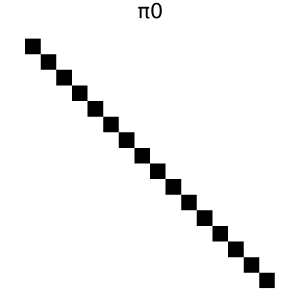

In [3]:
# Type of initialization
#key = "product"
key = "flipped"
N = 32
c(x,y) = l22(x,y)
solver = domdec_sinkhorn_autofix_log!
ε = compute_epsilon(N; schedule = "squared")
iters = []
P0, tfinal = get_initial_plan_and_tfinal(key, N)
P0.partk = 0
heatmap(plan_to_dense_matrix(P0, c), title = "π0",c = cmap, clim = (0,0.25/N))

Then we run iterations of the domain decomposition until convergence, and equip each iteration with a timestep of $\Delta t = 1/n$. This produces a trajectory in the space of feasible couplings.

Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOTExamples.jl/tmp.gif")
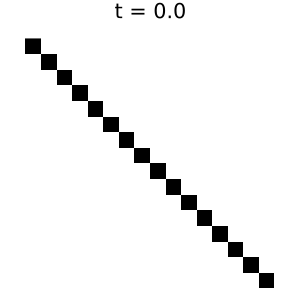

In [4]:
P = deepcopy(P0)
iter_params = (; default_params..., epsilon = ε, solver_verbose = false)
plans = []
anim = @animate for k in 1:Int(ceil(N*tfinal))+1
    A = plan_to_dense_matrix(P, c, false)
    heatmap(A, title = "t = $(round((k-1)/N, digits = 2))",c = cmap, clim = (0,0.5/N))
    # Iterate
    Npart = length(P.composite_cells)
    P.epsilon = iter_params[:epsilon]
    k0 = (k-1)%Npart+1
    iterate_parallel!(P, k0, c, solver, iter_params)
end
Logging.disable_logging(Logging.Info)
gif(anim, fps = 4)

To see the asymptotic behavior emerge we compute these iterations for values of $N=32, 64, 128$ and for three different schedules for $\varepsilon_N$: 
* `squared`: $\varepsilon_N = C_0/N^2$
* `linear`: $\varepsilon_N = C_1/N$
* `constant`: $\varepsilon_N = C_2$
where the constants are chosen in such a way that the value of $\varepsilon_32$ is the same for all schedules.

As explained in the article, the limit behavior is heavily influenced by this schedule of refinement of $\varepsilon$. For the `squared` sequence, the trajectories get increasisly "crisp" as $N$ increases. For the `linear` schedule this still holds, but there is some amount of blur appreciated at every step, making the actual change of rate of the limit trajectory slower. Finally, for the `constant` schedule, the trajectory lags behind more and more as $N$ incrases, so that the limit trajectory is effectively frozen at the initialization $\pi^0$.

Below we compute and plot these trajectories. Remember that you can change the initialization above.

In [5]:
iters_dict = Dict()
for N in [32, 64, 128]
    for refinement_schedule in ["squared", "linear", "constant"]
        println("Computing iterations for N = ", N, ", schedule = ", refinement_schedule)
        plans = []
        ε = compute_epsilon(N,schedule = refinement_schedule)
        P, tfinal = get_initial_plan_and_tfinal(key, N)
        iter_params = (; default_params..., epsilon = ε, solver_verbose = false)
        push!(iters, plan_to_dense_matrix(P, c))
        N_iter = Int(ceil(N*tfinal))
        Npart = length(P.composite_cells)
        for k in 1:N_iter
            P.epsilon = iter_params.epsilon
            k0 = (k-1)%Npart+1
            iterate_parallel!(P, k0, c, solver, iter_params)
            push!(plans, plan_to_dense_matrix(P, c))
        end
        push!(iters_dict, (N, refinement_schedule) => plans)
    end
end

Computing iterations for N = 32, schedule = squared
Computing iterations for N = 32, schedule = linear
Computing iterations for N = 32, schedule = constant
Computing iterations for N = 64, schedule = squared
Computing iterations for N = 64, schedule = linear
Computing iterations for N = 64, schedule = constant
Computing iterations for N = 128, schedule = squared
Computing iterations for N = 128, schedule = linear
Computing iterations for N = 128, schedule = constant


Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOTExamples.jl/tmp.gif")
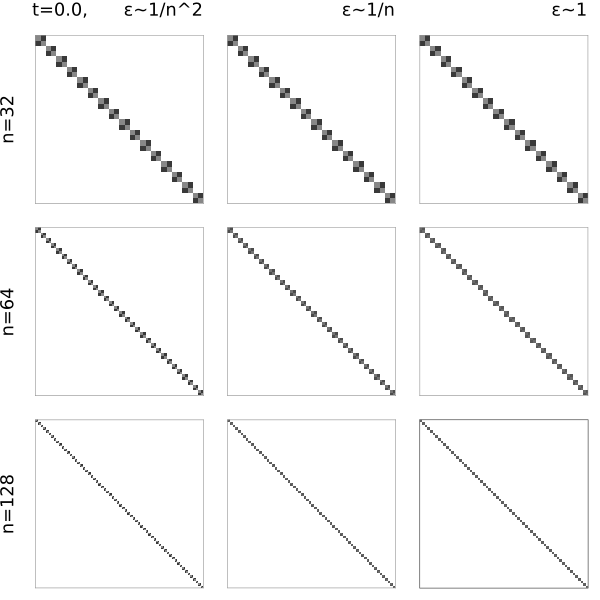

In [6]:
titles = Dict("squared"=>"ε∼1/n^2", "linear"=>"ε∼1/n", "constant"=>"ε∼1")
anim = @animate for t in 0:1/128:tfinal
    plots = []
    for (i,N) in enumerate([32, 64, 128])
        for (j, refinement_schedule) in enumerate(["squared", "linear", "constant"])
            k = Int(floor(N*t))+1
            
            p = heatmap(iters_dict[(N, refinement_schedule)][k], c = cmap, 
                                    clim = (0,0.8/N); titlefontsize = 12, )
            vline!([0.5, N+0.5], c = :gray, linewidth = 1)
            hline!([0.5, N+0.5], c = :gray, linewidth = 1)
            if i == 1
                title!(" ")
                if j == 1
                    annotate!(p, 0, 1.17N,text("t=$(round(t, digits = 3)),", 12, :left))
                end
                
                annotate!(p, N, 1.17N,text("$(titles[refinement_schedule])", 12, :right))
            end
            if j == 1
                ylabel!("n=$N", ylabelfontsize=12)
            end
            push!(plots, p)
            
        end
    end
    plot(plots..., layout = (3,3), size = (600,600), suptitle = t)
end

Logging.disable_logging(Logging.Info) # For privacy reasons
gif(anim, fps = 4)